# Citi Bike NYC Ridetime Analysis: Exploring patterns and building prediction

## Introduction

The aim of this notebook is to try to predict ride time of user for Citi Bike bycicle sharing system inside New York City by using only initial ride information and weather. Work consists of several steps:
1. Data cleaning
2. Exploratory Data Analysis
3. Hypothesis Testing
4. Building prediction model

## Data Sources

- **Citi Bike Trip Data**: Publicly available from official Citi Bike system data portal: https://citibikenyc.com/system-data. Extracted data covers period from 2024-01-01 to 2025-06-01.
- **Weather Data**: Historical data for NYC was obtained from https://openweathermap.org/history-bulk. This dataset was purchased to supplement trips data and covers period from 2024-01-01 to 2025-06-01.



## Data Loading & Cleaning

In [1]:
import os
from dotenv import load_dotenv

from google.cloud import bigquery

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import f_oneway

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [3]:
sns.set_style("whitegrid")

In [4]:
load_dotenv()

True

In [5]:
client = bigquery.Client()

bq_project_id = os.getenv('GCP_PROJECT_ID')
bq_dataset_name = os.getenv('BQ_DATASET')
bq_trips_table_name = os.getenv('BQ_TABLE_TRIPS')
bq_weather_table_name = os.getenv('BQ_TABLE_WEATHER')

table_ref = f'{bq_project_id}.{bq_dataset_name}.{bq_trips_table_name}'
cleaned_table_ref = f'{bq_project_id}.{bq_dataset_name}.{bq_trips_table_name}_cleaned'
weather_table_ref = f'{bq_project_id}.{bq_dataset_name}.{bq_weather_table_name}'
cleaned_weather_table_ref = f'{bq_project_id}.{bq_dataset_name}.{bq_weather_table_name}_cleaned'

Fisrt step is to understand how data looks like, what columns and types it has.

In [59]:
query = f"""
    SELECT *
    FROM `{table_ref}`
    LIMIT 5
"""

df = client.query(query).to_dataframe()
df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,E754D558B22D7051,classic_bike,2025-04-04 15:52:20.202000+00:00,2025-04-05 16:52:00.689000+00:00,Church Ave & McDonald Ave,3090.06,None,nan,40.642809,-73.979239,NaN,NaN,casual
1,17B72EFFA5078EEC,classic_bike,2025-04-04 13:51:37.723000+00:00,2025-04-05 14:51:33.824000+00:00,Clinton St & Union St,4266.03,None,nan,40.683116,-73.997853,NaN,NaN,casual
2,2CE8AB625D2E7757,classic_bike,2025-04-04 17:12:32.491000+00:00,2025-04-05 18:12:23.001000+00:00,Bond St & Fulton St,4479.06,None,nan,40.689622,-73.983043,NaN,NaN,casual
3,8481CCEC9172D1B5,classic_bike,2025-04-04 20:19:56.280000+00:00,2025-04-05 21:19:50.100000+00:00,Van Buren St & Broadway,4568.01,None,nan,40.692000,-73.926170,NaN,NaN,casual
4,10A2EB7353012C90,classic_bike,2025-04-04 17:31:34.359000+00:00,2025-04-05 18:31:28.914000+00:00,Willoughby St & Fleet St,4628.05,None,nan,40.691966,-73.981302,NaN,NaN,casual


In [5]:
print(df.columns.values)

['ride_id' 'rideable_type' 'started_at' 'ended_at' 'start_station_name'
 'start_station_id' 'end_station_name' 'end_station_id' 'start_lat'
 'start_lng' 'end_lat' 'end_lng' 'member_casual']


In [6]:
df.dtypes

ride_id                            object
rideable_type                      object
started_at            datetime64[us, UTC]
ended_at              datetime64[us, UTC]
start_station_name                 object
start_station_id                   object
end_station_name                   object
end_station_id                     object
start_lat                         float64
start_lng                         float64
end_lat                           float64
end_lng                           float64
member_casual                      object
dtype: object


Focus be on such variables: *rideable_type*, *started_at*, *start_station_name*, *member_casual*. *start_station_id* and *start_lat* | *start_lng* are not taken into account because they will give same information as *start_station_name*.

Next is dealing with missing values.

In [12]:
query = f"""
    SELECT 
        COUNT(*) - COUNT(ride_id) as ride_id_null,
        COUNT(*) - COUNT(rideable_type) as rideable_type_null,
        COUNT(*) - COUNT(started_at) as started_at_null,
        COUNT(*) - COUNT(ended_at) as ended_at_null,
        COUNT(*) - COUNT(start_station_name) as start_station_name_null,
        COUNT(*) - COUNT(start_station_id) as start_station_idnull,
        COUNT(*) - COUNT(end_station_name) as end_station_name_null,
        COUNT(*) - COUNT(end_station_id) as end_station_id_null,
        COUNT(*) - COUNT(start_lat) as start_lat_null,
        COUNT(*) - COUNT(start_lng) as start_lng_null,
        COUNT(*) - COUNT(end_lat) as end_lat_null,
        COUNT(*) - COUNT(end_lng) as end_lng_null,
        COUNT(*) - COUNT(member_casual) as member_casual_null
    FROM `{table_ref}`
"""

df = client.query(query).to_dataframe()
df

,ride_id_null,rideable_type_null,started_at_null,ended_at_null,start_station_name_null,start_station_idnull,end_station_name_null,end_station_id_null,start_lat_null,start_lng_null,end_lat_null,end_lng_null,member_casual_null
0,0,0,0,0,35253,0,152745,0,0,0,12784,12784,0


As work goal is predicting on a initial data, so *start_station_name* can be important feature. As for *end_station_name*, *end_lat* and *end_lng* they will not be used and can be not considered. 
<br> 
<br>
Lets check for any *start_station_name* missing values pattern.

In [13]:
query = f"""
    SELECT *
    FROM `{table_ref}`
    WHERE start_station_name IS NULL
    LIMIT 5
"""

df = client.query(query).to_dataframe()
df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,BB947E92ADA0481D,electric_bike,2024-06-12 08:35:37.598000+00:00,2024-06-12 08:48:07.670000+00:00,None,nan,Kingston Ave & Montgomery St,3759.07,40.65,-73.96,40.664810,-73.942690,casual
1,58238DBF8BC50DDE,electric_bike,2024-06-12 17:04:35.639000+00:00,2024-06-12 17:12:10.928000+00:00,None,nan,Wilson Ave & Moffat St,4507.07,40.69,-73.91,40.689060,-73.905060,casual
2,9FBB757D2C62AB16,electric_bike,2024-06-12 18:36:09.571000+00:00,2024-06-12 18:48:37.153000+00:00,None,nan,Suydam St & Knickerbocker Ave,4939.07,40.71,-73.92,40.702013,-73.923769,casual
3,AAF98782C6089B2E,electric_bike,2024-06-12 14:40:47.990000+00:00,2024-06-12 14:45:59.825000+00:00,None,nan,University Pl & E 14 St,5905.14,40.74,-74.00,40.734814,-73.992085,casual
4,39A5636D51C91F3B,electric_bike,2024-06-12 19:53:11.913000+00:00,2024-06-12 20:28:13.922000+00:00,None,nan,90 St & 51 Ave,6080.07,40.74,-73.87,40.739370,-73.874110,casual


For null *start_station_name* feature *start_station_id* has string value 'nan'. Is it case for all rows?

In [14]:
query = f"""
    SELECT COUNT(*) as cnt
    FROM `{table_ref}`
    WHERE start_station_name IS NULL AND start_station_id != 'nan'
"""

df = client.query(query).to_dataframe()
df

,cnt
0,0


There are no such rows.

Any rows where *start_station_id* is 'nan' but *start_station_name* is not null?

In [15]:
query = f"""
    SELECT COUNT(*) as cnt
    FROM `{table_ref}`
    WHERE start_station_name IS NOT NULL AND start_station_id = 'nan'
"""

df = client.query(query).to_dataframe()
df

,cnt
0,0


There are no such rows as well.

As it is same for all missing values and 30k is relatively small to 60m, entries with null *start_station_name* can be  removed to ensure accuracy of analysis and prediction.

In [22]:
query = f"""
    CREATE OR REPLACE TABLE {cleaned_table_ref}
    PARTITION BY DATE_TRUNC(started_at, MONTH)
    CLUSTER BY member_casual, rideable_type 
        AS
            SELECT * FROM `{table_ref}`
            WHERE start_station_id != 'nan'
"""

job = client.query(query)
job.result()


Next step is to check for ride time invlaid values like negative duration or too long ride.

In [23]:
query = f"""
    SELECT 
        MIN(TIMESTAMP_DIFF(ended_at, started_at, MINUTE)) as min_ride_time,
        MAX(TIMESTAMP_DIFF(ended_at, started_at, MINUTE)) as max_ride_time
    FROM {cleaned_table_ref}
"""

df = client.query(query).to_dataframe()
print(f'Minimum time is {df['min_ride_time'].iloc[0]} minutes and maximum time is {df['max_ride_time'].iloc[0]} minutes.')

Minimum time is -57 minutes and maximum time is 1559 minutes.


Minimum ride time is -57 minutes, which, of course, cannot be true.

For one-time ride and Day Pass Citi Bike provides 30 minutes, after which user will be additionally charged $0.38/min. For users, who have year subscription ride is 45 minutes and after that $0.25/min: https://citibikenyc.com/pricing.


It is highly unlikely, that user will drive 1559 minutes. For casual users it will be additional cost of $581.02 and for members $378.5.

Let's see the proportions of rides less than 2 minutes, more than 45 minutes and more than 2 hours.

In [24]:
query = f"""
 SELECT
  COUNT(*) AS total_trips,
  AVG(TIMESTAMP_DIFF(ended_at, started_at, MINUTE)) as avg_time,
  ROUND(100 * COUNTIF(TIMESTAMP_DIFF(ended_at, started_at, MINUTE) < 2) / COUNT(*), 2) AS pct_less_2_min,
  ROUND(100 * COUNTIF(TIMESTAMP_DIFF(ended_at, started_at, MINUTE) > 45) / COUNT(*), 2) AS pct_over_45_min,
  ROUND(100 * COUNTIF(TIMESTAMP_DIFF(ended_at, started_at, MINUTE) > 120) / COUNT(*), 2) AS pct_over_2_hours
FROM
  {cleaned_table_ref}
WHERE
  ended_at IS NOT NULL
  AND started_at IS NOT NULL
"""

df =  client.query(query).to_dataframe()
df

,total_trips,avg_time,pct_less_2_min,pct_over_45_min,pct_over_2_hours
0,59738507,12.582068,3.41,2.03,0.24


Rides with duration less than 2 minutes are most likely test rides and do not show usual user behaviour.

Rides slighly over 45 minutes are highly possible as users can miss moment when they need to change bike to reset time.

But rides over 2 hours are unlikely as they have great additional cost. 

Time that is less than 2 minutes and more than 2 hours will be filtered out.

In [25]:
query = f"""
    DELETE
    FROM {cleaned_table_ref}
    WHERE 
        TIMESTAMP_DIFF(ended_at, started_at, MINUTE) < 2 
    OR 
        TIMESTAMP_DIFF(ended_at, started_at, MINUTE) > 120
"""

job = client.query(query)
job.result()

Proper *start_station_id* has 4 digits before point and 2 digits after point (e.g. 4074.17)

In [26]:
regex = r'^\d{4}\.\d{2}$'

query = f"""
    SELECT start_station_id
    FROM {cleaned_table_ref}
    WHERE NOT REGEXP_CONTAINS(start_station_id, r'{regex}')
    GROUP BY start_station_id;
"""

df = client.query(query).to_dataframe()
df

,start_station_id
0,4137.1
1,7388.1
2,6242.1
3,5872.1
4,5854.1
...,...
174,JC008
175,JC074
176,JC018
177,JC022


IDs like JC075 correspond to New Jersey stations. As analysis and presiction focuses on rides only inside NYC, such entries can be removed.

In [27]:
regex = r'^[A-Za-z]{2}\d{3}$'

query = f"""
    DELETE 
    FROM {cleaned_table_ref}
    WHERE REGEXP_CONTAINS(start_station_id, r'{regex}') OR REGEXP_CONTAINS(end_station_id, r'{regex}')
"""

job = client.query(query)
job.result()

Now let's see remaining IDs.

In [28]:
regex = r'^\d{4}\.\d{2}$'

query = f"""
    SELECT start_station_id, COUNT(*)
    FROM {cleaned_table_ref}
    WHERE NOT REGEXP_CONTAINS(start_station_id, r'{regex}')
    GROUP BY start_station_id;
"""

df = client.query(query).to_dataframe()
df

,start_station_id,f0_
0,3776.1,606
1,4821.1,2889
2,4994.1,1111
3,5430.1,3554
4,5872.1,8676
...,...,...
112,8647.1,150
113,8416.1,581
114,Lab - NYC - Monolith,7
115,5308.04_,44


IDs like 4366.1 seem to miss 0 at the end. But at first check if the *start_station_name* of these ivalid IDs are the same as for IDs with 0 at the end.

In [29]:
# Check if by cleaning invalid start_station_id it will have same start_station_name as valid one.
def find_corresponding_station(regex_invalid_id, regex_valid_id, replace_id_query):
    query = f"""
        WITH invalid AS ( 
            SELECT start_station_id, start_station_name
            FROM {cleaned_table_ref}
            WHERE REGEXP_CONTAINS(start_station_id, r'{regex_invalid_id}')
            GROUP BY start_station_id, start_station_name
        ), 
        valid AS (
            SELECT start_station_id, start_station_name
            FROM {cleaned_table_ref}
            WHERE REGEXP_CONTAINS(start_station_id, r'{regex_valid_id}')
            GROUP BY start_station_id, start_station_name
        )
        SELECT * 
        FROM invalid
        LEFT JOIN valid 
            ON {replace_id_query} = valid.start_station_id
    """

    df = client.query(query).to_dataframe()
    return df

In [30]:
regex_invalid_id = r'^\d{4}\.\d{1}$'
regex_valid_id = r'^\d{4}\.\d{2}$'

replace_id_query = "CAST(FORMAT('%.2f', CAST(invalid.start_station_id AS FLOAT64)) AS STRING)"

df = find_corresponding_station(regex_invalid_id, regex_valid_id, replace_id_query)
df

,start_station_id,start_station_name,start_station_id_1,start_station_name_1
0,6332.1,Broadway & 74 St,6332.10,Broadway & 74 St
1,6364.1,6 Ave & W 34 St,6364.10,6 Ave & W 34 St
2,4249.1,St Marks Pl & 4 Ave,4249.10,St Marks Pl & 4 Ave
3,6923.2,31 St & Newtown Ave,6923.20,31 St & Newtown Ave
4,7669.1,E 138 St & Cypress Ave,7669.10,E 138 St & Cypress Ave
...,...,...,...,...
101,5024.1,Water St & Fletcher St,5024.10,Water St & Fletcher St
102,5779.1,E 14 St & 1 Ave,5779.10,E 14 St & 1 Ave
103,5854.1,Stuyvesant Walk & 1 Ave Loop,5854.10,Stuyvesant Walk & 1 Ave Loop
104,7230.1,W 74 St & Columbus Ave,7230.10,W 74 St & Columbus Ave


Stations with missing 0 in the end correspond to stations with proper IDs. Now it can be fixed with adding 0 to the end.

In [31]:
regex = r'^\d{4}\.\d{1}$'

query = f"""
    UPDATE {cleaned_table_ref}
    SET start_station_id = CAST(FORMAT('%.2f', CAST(start_station_id AS FLOAT64)) AS STRING)
    WHERE REGEXP_CONTAINS(start_station_id, r'{regex}')
"""
job = client.query(query)
job.result()

Again see remaining IDs.

In [32]:
regex = r'^\d{4}\.\d{2}$'

query = f"""
    SELECT start_station_id, COUNT(*)
    FROM {cleaned_table_ref}
    WHERE NOT REGEXP_CONTAINS(start_station_id, r'{regex}')
    GROUP BY start_station_id;
"""

df = client.query(query).to_dataframe()
df

,start_station_id,f0_
0,6247.06_Pillar,61
1,LA Metro Demo 2,8
2,SYS038,1239
3,SYS033,155
4,190 Morgan,5
5,LA Metro Demo 1,2
6,Shop Morgan,1037
7,Lab - NYC - Monolith,7
8,6569.09_,721
9,SYS025,1


IDs which look like SYS + 3 digits or contain words like 'Demo', 'Lab - NYC' and 'Morgan' will be removed as a potential stations for system purposes (testing, repairs) not for regular riders use.

In [33]:
regex_patterns = [
    r'^SYS\d{3}$',          # SYS + 3 digits
    r'(?i)Demo',            # Contains "Demo"
    r'(?i)Lab - NYC',       # Contains "Lab - NYC"
    r'(?i)Morgan'           # Contains "Morgan"
]

combined_pattern = '|'.join(regex_patterns)

query = f"""
    DELETE FROM {cleaned_table_ref}
    WHERE REGEXP_CONTAINS(start_station_id, r'{combined_pattern}')
"""

job = client.query(query)
job.result()

For IDs with underscore at the end (6569.09_) condact same check to see if they correspond to stations IDs with no underscore.

In [34]:
regex_invalid_id = r'^\d{4}\.\d{2}_$'
regex_valid_id = r'^\d{4}\.\d{2}$'

replace_id_query = "REPLACE(invalid.start_station_id, '_', '')"

df = find_corresponding_station(regex_invalid_id, regex_valid_id, replace_id_query)
df

,start_station_id,start_station_name,start_station_id_1,start_station_name_1
0,6569.09_,W 35 St & 9 Ave,6569.09,W 35 St & 9 Ave
1,5308.04_,Metropolitan Ave & Bedford Ave,5308.04,Metropolitan Ave & Bedford Ave


We can now remove underscore.

In [35]:
regex = r'^\d+\.\d+_$'

query = f"""
    UPDATE {cleaned_table_ref}
    SET 
        start_station_id = 
        CASE 
            WHEN REGEXP_CONTAINS(start_station_id, r'{regex}')
                THEN REPLACE(start_station_id, '_', '')
            ELSE start_station_id
        END
    WHERE 
        REGEXP_CONTAINS(start_station_id, r'{regex}')
"""

job = client.query(query)
job.result()

Same chech for IDs with _Pillar

In [36]:
regex_invalid_id = r'^\d{4}\.\d{2}_Pillar$'
regex_valid_id = r'^\d{4}\.\d{2}$'

replace_id_query = "REPLACE(invalid.start_station_id, '_Pillar', '')"

df = find_corresponding_station(regex_invalid_id, regex_valid_id, replace_id_query)
df

,start_station_id,start_station_name,start_station_id_1,start_station_name_1
0,6173.08_Pillar,Pillar Broadway & W 25 St,6173.08,Broadway & W 25 St
1,6247.06_Pillar,Pillar W 27 St & 7 Ave,6247.06,W 27 St & 7 Ave


Unlike other IDs, they also have Pillar in the name. It also should be removed.

In [37]:
regex_id = r'_Pillar$'
regex_name = r'(?i)\s*Pillar\s*'

query = f"""
    UPDATE {cleaned_table_ref}
    SET 
        start_station_id = CASE 
            WHEN REGEXP_CONTAINS(start_station_id, r'Pillar') THEN REGEXP_REPLACE(start_station_id, r'{regex_id}', '') 
            ELSE start_station_id END,
        start_station_name = CASE 
            WHEN REGEXP_CONTAINS(start_station_name, r'Pillar') THEN TRIM(REGEXP_REPLACE(start_station_name, r'{regex_name}', ' ')) 
            ELSE start_station_name END
        WHERE 
            REGEXP_CONTAINS(start_station_id, r'Pillar') OR
            REGEXP_CONTAINS(start_station_name, r'Pillar')
"""

job = client.query(query)
job.result()


In [38]:
query = f"""
    SELECT start_station_name, start_station_id, COUNT(*)
    FROM `{cleaned_table_ref}`
    WHERE start_station_id IS NULL OR SAFE_CAST(start_station_id AS FLOAT64) IS NULL
    GROUP BY start_station_name, start_station_id;
"""

df = client.query(query).to_dataframe()
df

,start_station_name,start_station_id,f0_


As all IDs are clean, we can now move on to check duplicate values. Does same *start_station_id* has more than one *start_station_name*?

In [39]:
query = f"""
    SELECT start_station_name, start_station_id
    FROM {cleaned_table_ref}
    GROUP BY start_station_name, start_station_id
"""

df = client.query(query).to_dataframe()
df[df['start_station_id'].duplicated(keep=False)].sort_values(by='start_station_id')

,start_station_name,start_station_id
1581,Eastern Pkwy & St Marks Ave,3982.01
1312,Eastern Pkwy\t& St Marks Ave,3982.01
1357,Bridge St & Water St,4968.03
1046,Bridge St & Front St,4968.03
171,Metropolitan Ave & Bedford Ave,5308.04
2227,Metropolitan Ave & Bedford Ave,5308.04
1324,Morton St & Greenwich St,5772.05
1860,Morton St & Washington St,5772.05
1725,34 Ave & Vernon Blvd,6873.01
847,34th Ave & Vernon Blvd,6873.01


Some stations are identified as duplicates because of different name formatting (e.g West | W). Also, **Ichan Stadium Plaza** station contains typo and should be **Icahn Stadium Plaza**.

In [40]:
convert_names = {
    'West': 'W',
    'Fort': 'Ft',
    'Av': 'Ave',
    'Ichan Stadium': 'Icahn Stadium'
}

sql_expr = "start_station_name"
for old, new in convert_names.items():
    sql_expr = f"REGEXP_REPLACE({sql_expr}, r'\\b{old}\\b', '{new}')"

conditions = []
for old, new in convert_names.items():
    conditions.append(f"start_station_name LIKE '%{old}%'")
clause = ' OR '.join(conditions)

query = f"""
    UPDATE {cleaned_table_ref}
    SET start_station_name = {sql_expr}
    WHERE {clause}
"""

job = client.query(query)
job.result()

Station **Eastern Pkwy\t& St Marks Ave** contains **\t** which should be removed.

In [41]:
pattern = r'\\t'

query = f"""
    UPDATE {cleaned_table_ref}
    SET start_station_name = REGEXP_REPLACE(start_station_name, r'{pattern}', ' ')
    WHERE REGEXP_CONTAINS(start_station_name, r'{pattern}')
"""

job = client.query(query)
job.result()

From search by station name using https://citibikenyc.com/homepage on 2025-07-02, there is no **Bridge St & Water St** station but **Bridge St & Front St**, no **Morton St & Washington St**, but **Morton St & Greenwich St**, no **3 Ave & E 81 St**, but **3 Ave & E 82 St**

In [42]:
convert_names = {
    'Bridge St & Water St': 'Bridge St & Front St',
    'Morton St & Washington St': 'Morton St & Greenwich St',
    '3 Ave & E 81 St': '3 Ave & E 82 St'
}

case_statements_start = []
for old, new in convert_names.items():
    case_statements_start.append(f"WHEN start_station_name = '{old}' THEN '{new}'")

query = f"""
    UPDATE {cleaned_table_ref}
    SET start_station_name = CASE {' '.join(case_statements_start)} ELSE start_station_name END
    WHERE start_station_name IN ({', '.join(f"'{old}'" for old in convert_names.keys())})
"""

job = client.query(query)
job.result()

**34th Ave & Vernon Blvd** contains ordinal suffix. It should be removed.

In [43]:
pattern = r'(\d+)(st|nd|rd|th)\b'
replace = r'\1'

query = f"""
    UPDATE {cleaned_table_ref}
    SET start_station_name = REGEXP_REPLACE(start_station_name, r'{pattern}', r'{replace}')
    WHERE REGEXP_CONTAINS(start_station_name, r'{pattern}')
"""

job = client.query(query)
job.result()

Remove any leading and trailing whitespaces and replace multiple spaces with a single space.

In [44]:
regex = r'^\s+|\s+$|\s{2,}'

query = f"""
    UPDATE {cleaned_table_ref}
    SET start_station_name = REGEXP_REPLACE(TRIM(start_station_name), r'\s+', ' ')
    WHERE REGEXP_CONTAINS(start_station_name, r'{regex}')
"""

job = client.query(query)
job.result()

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_7767/1832362109.py:7: SyntaxWarning: invalid escape sequence '\s'
  """


Check for any duplicates after cleaning.

In [45]:
query = f"""
    SELECT start_station_name, start_station_id, COUNT(*)
    FROM {cleaned_table_ref}
    GROUP BY start_station_name, start_station_id
"""

df = client.query(query).to_dataframe()
df[df['start_station_id'].duplicated(keep=False)].sort_values(by='start_station_id')

,start_station_name,start_station_id,f0_


No duplicate values left.

Finally, create new columns for further easier work with query, such as *day_of_week* and *ride_time*.

In [46]:
table = client.get_table(cleaned_table_ref)
schema = table.schema
new_columns = [
    bigquery.SchemaField("day_of_week", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("ride_time", "FLOAT", mode="NULLABLE")
]

new_schema = schema[:] + new_columns
table.schema = new_schema

client.update_table(table, ['schema'])

Table(TableReference(DatasetReference('nyc-transportation-462009', 'city_mobility_data'), 'citibike_nyc_trips_cleaned'))

In [47]:
query = f"""
    UPDATE {cleaned_table_ref}
    SET day_of_week = 
        CASE EXTRACT(DAYOFWEEK FROM started_at) 
            WHEN 1 THEN 'Sunday'
            WHEN 2 THEN 'Monday' 
            WHEN 3 THEN 'Tuesday'
            WHEN 4 THEN 'Wednesday'
            WHEN 5 THEN 'Thursday'
            WHEN 6 THEN 'Friday'
            WHEN 7 THEN 'Saturday'
        END,
        ride_time = TIMESTAMP_DIFF(ended_at, started_at, MINUTE)
    WHERE TRUE
"""

job = client.query(query)
job.result()

## Exploratory Data Analysis (EDA)

Start with checking *member_casual* to see different user categories.

In [7]:
query = f"""
    SELECT DISTINCT member_casual
    FROM {cleaned_table_ref}
"""

df = client.query(query).to_dataframe()
df

,member_casual
0,member
1,casual


And *rideable_type* for bike types.

In [8]:
query = f"""
    SELECT DISTINCT rideable_type
    FROM {cleaned_table_ref}
"""

df = client.query(query).to_dataframe()
df

,rideable_type
0,electric_bike
1,classic_bike


Is there any difference in average ride time between casuals and members?

In [112]:
query = f"""
    SELECT member_casual, AVG(ride_time) AS avg_time
    FROM {cleaned_table_ref}
    GROUP BY member_casual
"""

df = client.query(query).to_dataframe()

member_avg_time = df[df['member_casual'] == 'member']['avg_time'].iloc[0]
casual_avg_time = df[df['member_casual'] == 'casual']['avg_time'].iloc[0]

print(f'Average ridetime for members is {np.round(member_avg_time, 2)} minutes.')
print(f'Average ridetime for casual users is {np.round(casual_avg_time, 2)} minutes.')
print()
print(f'Difference is {np.round(np.abs(member_avg_time - casual_avg_time), 2)} minutes.')

Average ridetime for members is 10.79 minutes.
Average ridetime for casual users is 17.23 minutes.

Difference is 6.44 minutes.


6 minutes is a great indicator that *member_casual* can have strong influence on user ride time.

Is average time different for members and casuals on different bike types? 

In [113]:
query = f"""
    SELECT member_casual, rideable_type, AVG(ride_time) AS avg_time
    FROM {cleaned_table_ref}
    GROUP BY member_casual, rideable_type
"""

df = client.query(query).to_dataframe()

member_classic_time = df[(df['member_casual'] == 'member') & (df['rideable_type'] == 'classic_bike')]['avg_time'].iloc[0]
member_electric_time = df[(df['member_casual'] == 'member') & (df['rideable_type'] == 'electric_bike')]['avg_time'].iloc[0]

casual_classic_time = df[(df['member_casual'] == 'casual') & (df['rideable_type'] == 'classic_bike')]['avg_time'].iloc[0]
casual_electric_time = df[(df['member_casual'] == 'casual') & (df['rideable_type'] == 'electric_bike')]['avg_time'].iloc[0]

print(f'Average ridetime for members on classic bike is {np.round(member_classic_time, 2)} and on electric bike is {np.round(member_electric_time, 2)}.')
print(f'Average ridetime for casuals on classic bike is {np.round(casual_classic_time, 2)} and on electric bike is {np.round(casual_electric_time, 2)}.')

Average ridetime for members on classic bike is 10.69 and on electric bike is 10.84.
Average ridetime for casuals on classic bike is 19.41 and on electric bike is 16.41.


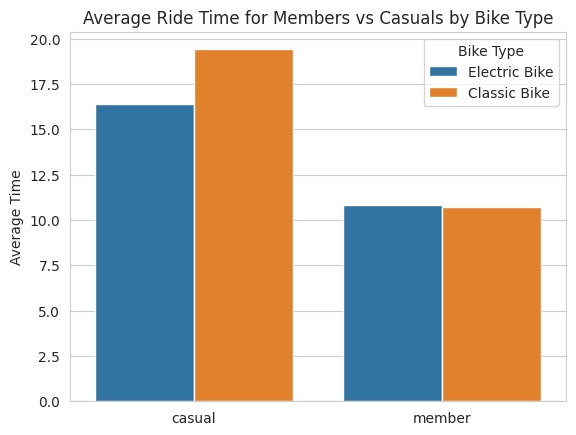

In [6]:
query = f"""
    SELECT member_casual, rideable_type, AVG(ride_time) AS avg_time
    FROM {cleaned_table_ref}
    GROUP BY member_casual, rideable_type
"""

df = client.query(query).to_dataframe()

ax = sns.barplot(data=df, x='member_casual', y='avg_time', hue='rideable_type')

handles, _ = ax.get_legend_handles_labels()

plt.title('Average Ride Time for Members vs Casuals by Bike Type')
plt.xlabel('')
plt.ylabel('Average Time')
plt.legend(title='Bike Type', handles=handles, labels=['Electric Bike', 'Classic Bike'])
plt.show()

Although members do not have any difference by bike type, it shows that casuals on average ride classic bike longer.

Check average time based on day of week.

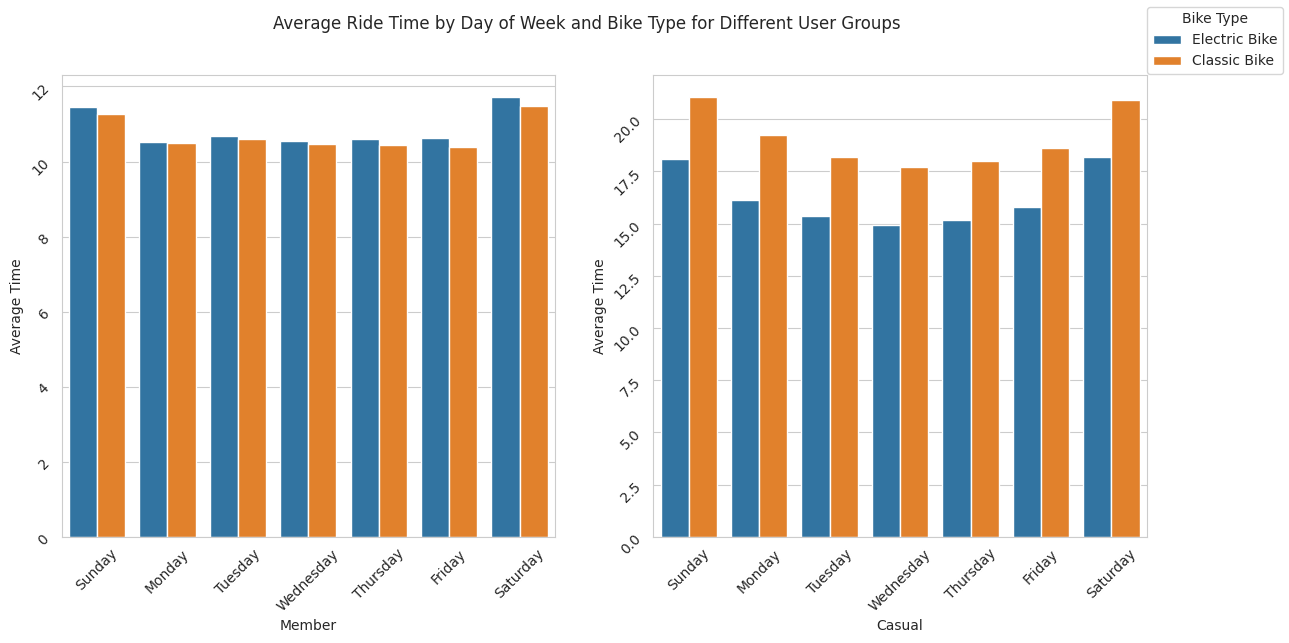

In [58]:
query = f"""
    SELECT 
        member_casual,
        rideable_type,
        day_of_week, 
        AVG(ride_time) as avg_time
        FROM {cleaned_table_ref}
    GROUP BY member_casual, rideable_type, day_of_week
"""

df = client.query(query).to_dataframe()

custom_dict = {'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6} 
df = df.sort_values(by='day_of_week', key=lambda x: x.map(custom_dict))

member_df = df[df['member_casual'] == 'member']
casual_df = df[df['member_casual'] == 'casual']

fig, ax = plt.subplots(1,2, figsize=(14, 6), sharex=True)

bar1 = sns.barplot(data=member_df, x='day_of_week', y='avg_time', hue='rideable_type', hue_order=['electric_bike', 'classic_bike'], ax=ax[0])
bar2 = sns.barplot(data=casual_df, x='day_of_week', y='avg_time', hue='rideable_type', hue_order=['electric_bike', 'classic_bike'], ax=ax[1])

labels = ['Electric Bike', 'Classic Bike']
handles, _ = bar1.get_legend_handles_labels()

ax[0].tick_params(labelrotation=45)
ax[0].get_legend().remove()
ax[0].set_xlabel('Member')
ax[0].set_ylabel('Average Time')

ax[1].tick_params(labelrotation=45)
ax[1].get_legend().remove()
ax[1].set_xlabel('Casual')
ax[1].set_ylabel('Average Time')

fig.legend(title='Bike Type', handles=handles, labels=labels, loc='upper right')

plt.suptitle('Average Ride Time by Day of Week and Bike Type for Different User Groups')
plt.show()

Members and casuals show different patterns of usage during the week. Members tend to ride longer on weekends and have around same time for each workday, while casual average time decreases by mid week and then start to increase.

Do hour trends have differences?

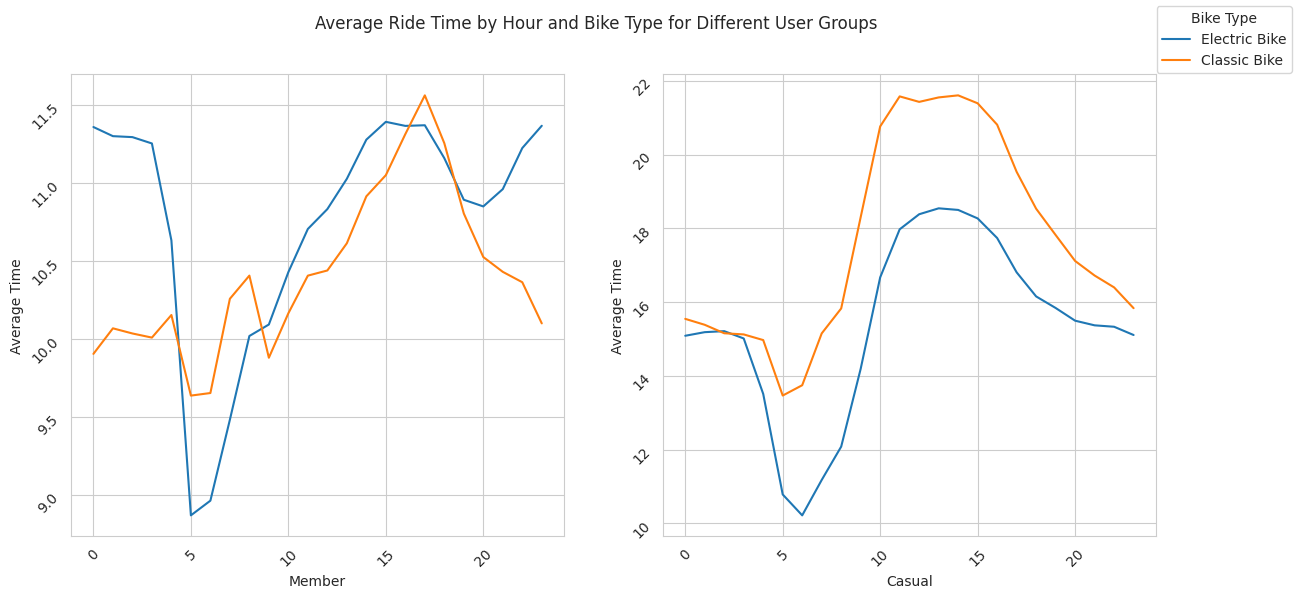

In [52]:
query = f"""
    SELECT 
        member_casual,
        rideable_type,
        EXTRACT(HOUR FROM started_at) as hour, 
        AVG(ride_time) as avg_time
        FROM {cleaned_table_ref}
    GROUP BY member_casual, rideable_type, hour
"""

df = client.query(query).to_dataframe()
df = df.sort_values(by='hour')

member_df = df[df['member_casual'] == 'member']
casual_df = df[df['member_casual'] == 'casual']

fig, ax = plt.subplots(1,2, figsize=(14, 6))

line1 = sns.lineplot(data=member_df, x='hour', y='avg_time', hue='rideable_type', hue_order=['electric_bike', 'classic_bike'], ax=ax[0])
line2 = sns.lineplot(data=casual_df, x='hour', y='avg_time', hue='rideable_type', hue_order=['electric_bike', 'classic_bike'], ax=ax[1])

labels = ['Electric Bike', 'Classic Bike']
handles, _ = line1.get_legend_handles_labels()

ax[0].tick_params(labelrotation=45)
ax[0].get_legend().remove()
ax[0].set_xlabel('Member')
ax[0].set_ylabel('Average Time')

ax[1].tick_params(labelrotation=45)
ax[1].get_legend().remove()
ax[1].set_xlabel('Casual')
ax[1].set_ylabel('Average Time')

fig.legend(title='Bike Type', handles=handles, labels=labels, loc='upper right')

plt.suptitle('Average Ride Time by Hour and Bike Type for Different User Groups')
plt.show()

For all groups. Average ride time increases from 5 am to peak at around 3pm and then decreases from 3pm to 5am respectively. 

Now check the statistic of ride time for each group by top 30 most popular start stations.

In [56]:
query = f"""
    SELECT start_station_name, AVG(ride_time) as avg_ride
    FROM {cleaned_table_ref}
    WHERE member_casual = 'member' AND rideable_type = 'classic_bike'
    GROUP BY start_station_name
    ORDER BY COUNT(*) DESC
    LIMIT 30
"""

df = client.query(query).to_dataframe()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_ride,30.0,10.153593,1.826928,6.749079,8.95196,9.840749,11.056347,16.022707


For members using classic bikes interquartile range (IQR) is 2 minutes. Considering that the average is 10 minutes and standart deviation is 1.82, this suggests a relatively small deviation in ride times.

In [55]:
query = f"""
    SELECT start_station_name, AVG(ride_time) as avg_ride
    FROM {cleaned_table_ref}
    WHERE member_casual = 'member' AND rideable_type = 'electric_bike'
    GROUP BY start_station_name
    ORDER BY COUNT(*) DESC
    LIMIT 30
"""

df = client.query(query).to_dataframe()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_ride,30.0,10.242454,0.936022,8.64326,9.514332,10.231167,10.740913,12.389036


Same for members using electric bike. IQR is only 1 minute with an average of 10 minutes.

In [53]:
query = f"""
    SELECT start_station_name, AVG(ride_time) as avg_ride
    FROM {cleaned_table_ref}
    WHERE member_casual = 'casual' AND rideable_type = 'classic_bike'
    GROUP BY start_station_name
    ORDER BY COUNT(*) DESC
    LIMIT 30
"""

df = client.query(query).to_dataframe()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_ride,30.0,25.201518,5.790302,15.86233,20.678327,23.946339,28.728095,37.169646


But for casuals situation is different. For classic bike IQR is 8.05 minutes, which is about 32% of the mean. Standart deviation is 5.79 minutes. That suggests a large deviation.

In [54]:
query = f"""
    SELECT start_station_name, AVG(ride_time) as avg_ride
    FROM {cleaned_table_ref}
    WHERE member_casual = 'casual' AND rideable_type = 'electric_bike'
    GROUP BY start_station_name
    ORDER BY COUNT(*) DESC
    LIMIT 30
"""

df = client.query(query).to_dataframe()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_ride,30.0,21.287636,7.073902,12.76908,16.016164,17.70479,27.401014,35.64091


For electric bike IQR and standart deviation are even higher - 11 and 7 minutes respectively. That is also a large deviation. 

We can conclude that ride time does not significantly depend on the start station for members, while for casual users, it has a greater impact.

## Hypothesis Testing

Conduct two-way ANOVA test to determine if there are any statistically significant differences in average time by membership and bike type, and whether there is an interaction effect between membership and bike type on ride time. 95% confidence.

In [ ]:
query = f"""
    WITH ranked AS (
        SELECT *, ROW_NUMBER() OVER (PARTITION BY member_casual, rideable_type ORDER BY ride_id) AS rn
        FROM {cleaned_table_ref}
    )

    SELECT * 
    FROM ranked
    WHERE rn <= 5000
"""

df = client.query(query).to_dataframe()

In [20]:
formula = 'ride_time ~ C(member_casual) + C(rideable_type) + C(member_casual):C(rideable_type)'
model = ols(formula, df).fit()
results = sm.stats.anova_lm(model, type=2)
results

,df,sum_sq,mean_sq,F,PR(>F)
C(member_casual),1.0,2.686958e+05,268695.812450,1576.953712,0.000000e+00
C(rideable_type),1.0,7.029422e+03,7029.422450,41.255105,1.366112e-10
C(member_casual):C(rideable_type),1.0,1.217268e+04,12172.680450,71.440464,3.050733e-17
Residual,19996.0,3.407102e+06,170.389156,NaN,NaN


The p-values for the factors in the output show that all factors significantly affect ride time (p < 0.05).

In [ ]:
query = f"""
    WITH ranked AS (
        SELECT *, ROW_NUMBER() OVER (PARTITION BY day_of_week ORDER BY ride_id) AS rn
        FROM {cleaned_table_ref}
    )

    SELECT * 
    FROM ranked
    WHERE rn <= 15000
"""

df = client.query(query).to_dataframe()

Next, test significance of observed differences in ride time based on day of the week using one-way ANOVA. 95% confidence.

In [ ]:
day_groups = [group['ride_time'].values for _, group in df.groupby('day_of_week')]

f_stat, p_val = f_oneway(*day_groups)

print("F =", f_stat, ", p =", p_val)

Member users: F = 100.66783836554634 , p = 7.486481436879072e-127


The p-value is much smaller than 0.05, indicating that the day of the week has a statistically significant effect on ride time.

Test differences in ride time based on hour. 95% confidence.

In [ ]:
query = f"""
    WITH ranked AS (
        SELECT *, 
            ROW_NUMBER() OVER (PARTITION BY EXTRACT(HOUR FROM started_at) ORDER BY RAND()) as rn,
            EXTRACT(HOUR FROM started_at) AS hour
        FROM {cleaned_table_ref}
    )

    SELECT *
    FROM ranked
    WHERE rn <= 500
"""

df = client.query(query).to_dataframe()

In [ ]:
hour_groups = [group['ride_time'].values for _, group in df.groupby('hour')]

f_stat, p_val = f_oneway(*hour_groups)

print("F =", f_stat, ", p =", p_val)

F = 4.695992477183007 , p = 6.629793025812667e-13


Again, p-value is much smaller than 0.05. That means hour has a statistically significant effect.

Lastly, test top 30 stations by populatity. One-way ANOVA, 95% confidence.

In [ ]:
query = f"""
    WITH top_30_stations AS (
        SELECT start_station_name
        FROM {cleaned_table_ref}
        GROUP BY start_station_name
        ORDER BY COUNT(*) DESC
        LIMIT 30
    ),

    ranked AS (
        SELECT *,
            ROW_NUMBER() OVER (PARTITION BY c.start_station_name ORDER BY RAND()) as rn
        FROM {cleaned_table_ref} c
        WHERE c.start_station_name IN (SELECT start_station_name FROM top_30_stations)
    )

    SELECT * 
    FROM ranked
    WHERE rn <= 500
"""

df = client.query(query).to_dataframe()

In [ ]:
station_groups = [group['ride_time'].values for _, group in df.groupby('start_station_name')]

f_stat, p_val = f_oneway(*station_groups)

print("F =", f_stat, ", p =", p_val)

F = 59.43272973021563 , p = 0.0


Statistically significant effect.

## Ride Time Prediction

Last step is to predict ride time based on inital data. As data does not have linear relationships, a machine learning algorithm - Random Forest - will be used.

In [ ]:
query = f"""
    SELECT 
        ride_time,
        start_station_name,
        EXTRACT(HOUR FROM started_at) as start_hour,
        day_of_week,
        member_casual,
        rideable_type,
    FROM {cleaned_table_ref}
    LIMIT 1000000
"""

df = client.query(query).to_dataframe()

In [22]:
x = df.drop(columns=['ride_time'])
y = df['ride_time']

label_encoder = LabelEncoder()
X_categorical = x.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
X_numerical = x.select_dtypes(exclude=['object'])

X = pd.concat([pd.DataFrame(X_numerical), X_categorical], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")

MSE: 154.14
R² Score: 0.03


RMSE (√MSE) = ~12.41 minutes, which is almost equal to the average ride time (12.5 minutes). Model is not doing much better than simply predicting the mean ride time for every case. 

R² Score is 0.03. Model explains only 3% of variability.

Initial data that provided by Citi Bike is insufficient to predict ride time. Model needs larger set of features to improve accuracy.

Weather data can give some of them.

In [48]:
job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows=1,
    autodetect=True,
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)

with open('./weather_nyc.csv', 'rb') as weather_file:
    load_job = client.load_table_from_file(
        weather_file,
        weather_table_ref,
        job_config=job_config
    )
    
load_job.result()

LoadJob<project=nyc-transportation-462009, location=EU, id=ad0b6b33-fc99-4a1b-aca6-8619a70feb8c>

In [4]:
query = f"""
    SELECT * FROM {weather_table_ref}
    LIMIT 5
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1704067200,2024-01-01 00:00:00 +0000 UTC,-18000,New York,40.712775,-74.005973,5.61,10000,-2.18,2.29,...,0.0,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n
1,1704070800,2024-01-01 01:00:00 +0000 UTC,-18000,New York,40.712775,-74.005973,5.70,10000,-1.90,2.95,...,0.0,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n
2,1704074400,2024-01-01 02:00:00 +0000 UTC,-18000,New York,40.712775,-74.005973,5.54,10000,-1.41,2.20,...,0.0,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n
3,1704078000,2024-01-01 03:00:00 +0000 UTC,-18000,New York,40.712775,-74.005973,5.71,10000,-1.07,2.96,...,0.0,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n
4,1704081600,2024-01-01 04:00:00 +0000 UTC,-18000,New York,40.712775,-74.005973,5.65,10000,-0.93,2.89,...,0.0,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n


In [6]:
df.columns

Index(['dt', 'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'temp',
       'visibility', 'dew_point', 'feels_like', 'temp_min', 'temp_max',
       'pressure', 'sea_level', 'grnd_level', 'humidity', 'wind_speed',
       'wind_deg', 'wind_gust', 'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h',
       'clouds_all', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon'],
      dtype='object')

*temp*, *visibility*, *humidity*, *wind_speed*, *rain_1h*, *snow_1h*, *weather_main* can potentially be important features.

In [14]:
query = f"""
    CREATE OR REPLACE VIEW {cleaned_weather_table_ref} AS
        SELECT
        *,
        TIMESTAMP(REPLACE(dt_iso, ' +0000 UTC', '')) AS dt_iso_ts
        FROM {weather_table_ref}
"""

job = client.query(query)
job.result()

List average time by weather types.

In [41]:
query = f"""
    SELECT
        weather.weather_main, AVG(trips.ride_time) AS avg_time
    FROM
        {cleaned_table_ref} AS trips
    LEFT JOIN
        {cleaned_weather_table_ref} AS weather
    ON DATETIME_TRUNC(DATETIME(trips.started_at), HOUR) =
        DATETIME_TRUNC(DATETIME(weather.dt_iso_ts, 'America/New_York'), HOUR)
    WHERE weather.weather_main IS NOT NULL
    GROUP BY weather.weather_main
"""

df = client.query(query).to_dataframe()
df.describe()

,avg_time
count,9.000000
mean,10.896673
std,1.088047
min,9.257573
25%,10.095436
50%,11.010293
75%,12.037056
max,12.166578


IQR is only 2 minutes, which shows small deviation, though it is still 20% of the mean and can be used for prediction.

Count trips for all weather types.

In [44]:
query = f"""
    SELECT
        weather.weather_main, COUNT(*) AS cnt
    FROM
        {cleaned_table_ref} AS trips
    LEFT JOIN
        {cleaned_weather_table_ref} AS weather
    ON DATETIME_TRUNC(DATETIME(trips.started_at), HOUR) =
        DATETIME_TRUNC(DATETIME(weather.dt_iso_ts, 'America/New_York'), HOUR)
    WHERE weather.weather_main IS NOT NULL
    GROUP BY weather.weather_main
"""

df = client.query(query).to_dataframe()
df

,weather_main,cnt
0,Clouds,19361079
1,Mist,2357861
2,Drizzle,59087
3,Rain,6995654
4,Thunderstorm,42260
5,Fog,10654
6,Clear,29412601
7,Haze,541184
8,Snow,208609


Some categories like Fog are rare, <0.1% of data. It is important to group them into broader categories before retraining model, as they can cause overfitting.

Condact one-way ANOVA test for weather type with 95% confidence.

In [ ]:
query = f"""

    WITH weather_type_ride AS (
        SELECT 
            weather.weather_main,
            trips.ride_time
        FROM {cleaned_table_ref} AS trips
        LEFT JOIN {cleaned_weather_table_ref} AS weather
        ON CAST(DATETIME_TRUNC(DATETIME(trips.started_at), HOUR) AS STRING) =
            CAST(DATETIME_TRUNC(DATETIME(TIMESTAMP(weather.dt_iso_ts), 'America/New_York'), HOUR) AS STRING)
    ),

    ranked AS (
        SELECT *,
            ROW_NUMBER() OVER (PARTITION BY weather_main ORDER BY RAND()) as rn,
        FROM weather_type_ride
    )

    SELECT * 
    FROM ranked
    WHERE rn <= 500
"""

df = client.query(query).to_dataframe()

In [64]:
weather_groups = [group['ride_time'].values for _, group in df.groupby('weather_main')]

f_stat, p_val = f_oneway(*weather_groups)

print("F =", f_stat, ", p =", p_val)

F = 5.697855929708082 , p = 3.1127861759242917e-07


p-values is smaller than 0.05. Weather type has a statistically significant difference on ride time.

Next, check if *temp*, *visibility*, *humidity*, *wind_speed*, *rain_1h* and *snow_1h* have linear correlation with ride time.

In [12]:
def check_correlation(param):
    query = f"""
        SELECT
            trips.ride_time,
            weather.{param}
        FROM
            {cleaned_table_ref} AS trips
        LEFT JOIN
            {cleaned_weather_table_ref} AS weather
        ON DATETIME_TRUNC(DATETIME(trips.started_at), HOUR) =
            DATETIME_TRUNC(DATETIME(weather.dt_iso_ts, 'America/New_York'), HOUR)
        WHERE 
            trips.ride_time IS NOT NULL
            AND weather.{param} IS NOT NULL
        LIMIT 1000000
    """

    df = client.query(query).to_dataframe()
    return df.corr()['ride_time']

Temperature

In [13]:
df = check_correlation('temp')
df

ride_time    1.000000
temp         0.241459
Name: ride_time, dtype: float64

Though 0.24 is a relatively small positive correlation, *temp* can be used as additional feature for model.

Check for *visibility*

In [14]:
df = check_correlation('visibility')
df

ride_time     1.000000
visibility    0.035441
Name: ride_time, dtype: float64

No correlation.

Now *humidity*.

In [15]:
df = check_correlation('humidity')
df

ride_time    1.000000
humidity    -0.080936
Name: ride_time, dtype: float64

No correlation.

Wind speed.

In [16]:
df = check_correlation('wind_speed')
df

ride_time     1.000000
wind_speed    0.035381
Name: ride_time, dtype: float64

No correlation.

Check correlation with *rain_1h*, rain volume for the last hour.

In [17]:
df = check_correlation('rain_1h')
df

ride_time    1.000000
rain_1h      0.007422
Name: ride_time, dtype: float64

No correlation.

Same for *snow_1h*, snow volume for the last hour.

In [18]:
df = check_correlation('snow_1h')
df

ride_time    1.000000
snow_1h      0.010707
Name: ride_time, dtype: float64

No correlation.

Only *weather_main* and *temp* show influence on tide time.

In [45]:
query = f"""
    SELECT
        trips.ride_time,
        weather.temp,
        weather.weather_main,
        trips.start_station_name,
        EXTRACT(HOUR FROM trips.started_at) as start_hour,
        trips.day_of_week,
        trips.member_casual,
        trips.rideable_type
    FROM
        {cleaned_table_ref} AS trips
    LEFT JOIN
        {cleaned_weather_table_ref} AS weather
    ON DATETIME_TRUNC(DATETIME(trips.started_at), HOUR) =
        DATETIME_TRUNC(DATETIME(weather.dt_iso_ts, 'America/New_York'), HOUR)
    WHERE 
        trips.ride_time IS NOT NULL
        AND weather.temp IS NOT NULL
        AND weather.weather_main IS NOT NULL
    LIMIT 1000000
"""

df = client.query(query).to_dataframe()

Group weather categories.

In [46]:
def group_weather(type):
    if type in ['Clear']:
        return 'Clear'
    elif type in ['Clouds']:
        return 'Cloudy'
    elif type in ['Rain', 'Drizzle', 'Thunderstorm']:
        return 'Rainy'
    elif type in ['Mist', 'Haze', 'Fog']:
        return 'Foggy/Misty'
    elif type in ['Snow']:
        return 'Snowy'
    else:
        return 'Other'
    
df['weather_main_grouped'] = df['weather_main'].apply(group_weather)

In [47]:
x = df.drop(columns=['ride_time', 'weather_main'])
y = df['ride_time']

label_encoder = LabelEncoder()
X_categorical = x.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
X_numerical = x.select_dtypes(exclude=['object'])

X = pd.concat([pd.DataFrame(X_numerical), X_categorical], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")

MSE: 202.53
R² Score: 0.15


Adding temperature and weather conditions improved the model’s ability to explain variability (R²), but increased prediction error (MSE), possibly due to overfitting.

In conclusion, data provided by Citi Bike combined with weather data are insufficient to create an accurate prediction. To improve performance, model needs additional features, such as age, gender, and occupation